<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">

# UNDER CONSTRUCTION

# snnTorch - Convolutional SNNs
## Tutorial 4
### By Jason K. Eshraghian (www.jasoneshraghian.com)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_4_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction
In this tutorial, you will:
* Train a convolutional SNN on the spiking MNIST dataset
* Develop strategies to promote sparse spiking
  * Use a spike-penalty regularization function
  * Compare latency coding and rate coding approaches
  * Test various rate coding target schemes ??

In [Tutorial 3](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_3_FCN.ipynb), we trained a fully-connected network on the static MNIST dataset. The theory surrounding SNNs was covered in detail, so we won't repeat what's already been said. This tutorial will take a hands-on approach.  

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install snntorch

# 1. Setting up the Spiking MNIST Dataset

## 1.1 Import packages and setup the environment

In [38]:
import snntorch as snn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [55]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Training Parameters
batch_size=128
data_path='/data/mnist'

# Temporal Dynamics
num_steps = 25
alpha = 0.95
beta = 0.9

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 1.2 Download MNIST Dataset

In [6]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

HTTPError: ignored

If the above code blocks throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [7]:
# # temporary dataloader if MNIST service is unavailable
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

--2021-03-24 04:30:26--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-24 04:30:26--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [    <=>             ]  33.20M  5.96MB/s    in 15s     

2021-03-24 04:30:41 (2.24 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [8]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 1.3 Spike Rate Coding

Part of the appeal of SNNs is their ability to handle time-varying spiking data. So let's use rate-coding to convert MNIST into spiking MNIST using the `spikegen` module, covered in Tutorial 1.

In [ ]:
train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

In [19]:
from snntorch import spikegen

# MNIST to spiking-MNIST
spike_data, spike_targets = spikegen.rate(train_loader.dataset[0][0], train_loader.dataset[0][1], num_outputs=num_outputs, num_steps=num_steps)

We will include the `rate` function within the training loop, to convert input samples into spikes before feeding them to the network.

## 1.4 Visualization

In [20]:
from snntorch import spikeplot as splt
from IPython.display import HTML

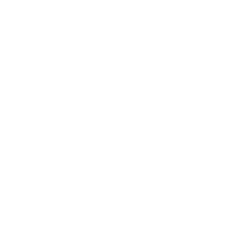

In [26]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data.squeeze(1), fig, ax)

HTML(anim.to_html5_video())

# 2. Define the Network

The network is almost the same as for static MNIST in Tutorial 3. There are two differences now:

1. It is a convolutional network
2. The input is time-varying, so we mustt iterate through time time-dimension

We can iterate through the time-dimension using the following line of code within the for-loop:

`cur1 = self.fc1(x[step])`

In [56]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

    # initialize layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta)
        self.fc2 = nn.Linear(64*5*5, 10)
        self.lif3 = snn.Stein(alpha=alpha, beta=beta)

    def forward(self, x):
        # Initialize LIF state variables and spike output tensors
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, 12, 13, 13)
        spk2, syn2, mem2 = self.lif1.init_stein(batch_size, 64, 5, 5)
        spk3, syn3, mem3 = self.lif2.init_stein(batch_size, 10)

        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            cur1 = F.max_pool2d(self.conv1(x[step]), 2)
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)
            cur3 = self.fc2(spk2.view(batch_size, -1))
            spk3, syn3, mem3 = self.lif3(cur3, syn3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

net = Net().to(device)

# 3. Training
We make a slight modification to our print-out functions to handle the new first dimension of the input:

In [57]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(spike_data, spike_targets, train=True)
    print_batch_accuracy(test_spike_data, test_spike_targets, train=False)
    print("\n")


## 7.1 Optimizer & Loss

In [58]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

## 7.2 Training Loop
The training loop is almost identical to the static MNIST case, but we pass each minibatch through `spikegen.rate` before feeding it to the feedforward network.

In [60]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    data = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator
        spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps)

        # Forward pass
        output, mem_rec = net(spike_data)
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward()
        # nn.utils.clip_grad_norm_(net.parameters(), 1) 

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data, test_spike_targets = spikegen.rate(testdata_it, testtargets_it, num_outputs=num_outputs,
                                                            num_steps=num_steps)

        # Test set forward pass
        test_output, test_mem_rec = net(test_spike_data)

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, test_spike_targets)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

Epoch 0, Minibatch 0
Train Set Loss: 11.301261901855469
Test Set Loss: 14.627947807312012
Train Set Accuracy: 0.9765625
Test Set Accuracy: 0.96875


Epoch 0, Minibatch 50
Train Set Loss: 13.425237655639648
Test Set Loss: 14.421419143676758
Train Set Accuracy: 0.9609375
Test Set Accuracy: 0.9453125


Epoch 0, Minibatch 100
Train Set Loss: 14.891846656799316
Test Set Loss: 14.88802433013916
Train Set Accuracy: 0.953125
Test Set Accuracy: 0.953125


Epoch 0, Minibatch 150
Train Set Loss: 13.654006004333496
Test Set Loss: 12.920709609985352
Train Set Accuracy: 0.9453125
Test Set Accuracy: 0.96875


Epoch 0, Minibatch 200
Train Set Loss: 13.156482696533203
Test Set Loss: 12.761216163635254
Train Set Accuracy: 0.9609375
Test Set Accuracy: 0.984375


Epoch 0, Minibatch 250
Train Set Loss: 14.670013427734375
Test Set Loss: 15.403223991394043
Train Set Accuracy: 0.96875
Test Set Accuracy: 0.953125


Epoch 0, Minibatch 300
Train Set Loss: 13.002306938171387
Test Set Loss: 11.96311092376709
Train

Spiking MNIST complete.

In [71]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    data_it, targets_it = data
    data_it = data_it.to(device)
    targets_it = targets_it.to(device)

    spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps)

    # If current batch matches batch_size, just do the usual thing
    if spike_data.size()[1] == batch_size:
      spk_rec, _ = net(spike_data)

    # If current batch does not match batch_size (i.e., is the final batch),
    # modify batch_size in a temp variable and restore it at the end
    else:
      temp_bs = batch_size
      batch_size = spike_data.size()[1]
      spk_rec, _ = net(spike_data)
      batch_size = temp_bs

    _, predicted = spk_rec.sum(dim=0).max(1)
    total += targets_it.size(0)
    correct += (predicted == targets_it).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

Total correctly classified test set images: 9748/10000
Test Set Accuracy: 97.48%


In [74]:
spk_rec.size()

torch.Size([25, 16, 10])

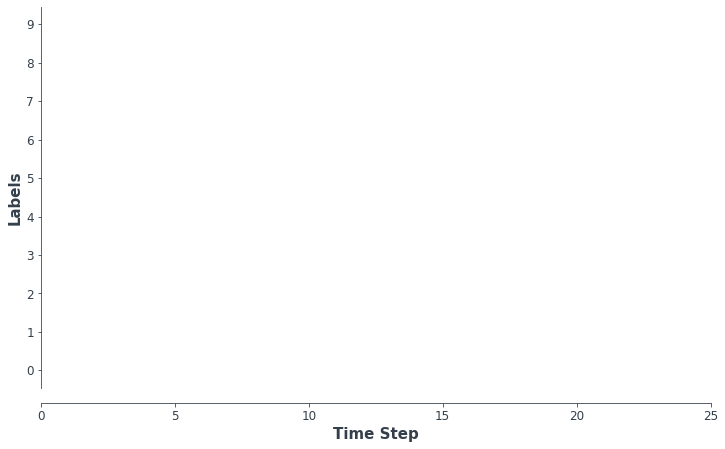

In [85]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk_rec = spk_rec.squeeze(1).detach().cpu()

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, 5], fig, ax, labels=labels, animate=True, interval=25, interpolate=10)
HTML(anim.to_html5_video())
# anim.save("spike_bar.gif")

If this was your first time training an SNN, then congratulations!

# 6. Results
## 6.1 Plot Training/Test Loss

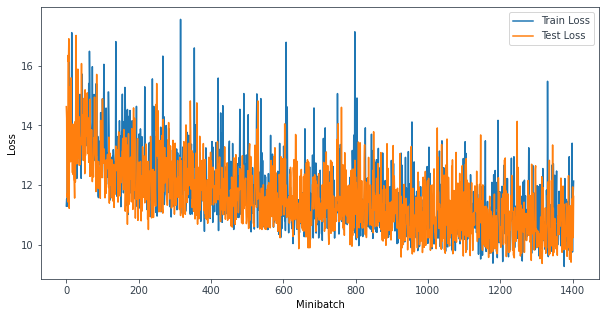

In [86]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.show()

Taking a look at the training / test loss, the process is somewhat noisy. This could be a result of a variety of things: minibatch gradient descent is the obvious one, but the use of improper targets likely also contributes. By encouraging the correct class to fire at every time step, the loss function conflicts with the reset mechanism that tries to prevent this.

## 6.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

## 8. Spiking MNIST Results
### 8.1 Plot Training/Test Loss

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 8.2 Test Set Accuracy

In [ ]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps)

      outputs, _ = net(spike_test)

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps)

      outputs, _ = net(spike_test)
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += spike_targets.size(0)
    correct += (predicted == spike_targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

That's all for now!
Next time, we'll introduce how to use spiking convolutional layers to improve accuracy.